## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


Два подхода очень похожи. И в том, и в другом случае происходит поиск похожих пользователей (ближайших соседей при  item-item подходе или объединение пользователей в группы "по интересам" при user-user подходе) с целью найти товары, которые могли бы конкретного пользователя заинтересовать.

Отличие в том, что при user-user подходе мы сначала разобьем пользователей на группы "по интересам", и только потом будем искать товары, которые покупают другие пользователи этой группы, а наш пользователь еще не покупал.

При item-item подходе мы отталкиваемся от купленного пользователем товара. Ищем другие, в чем-то похожие товары, который могли бы пользователя заинтересовать, принимая во внимание оценки, данные этим товарам его ближайшими соседями.

Поэтому функция item_item_rec(interaction_matrix) для user_user_rec не подойдет.

При ALS подходе мы разбиваем пользователей на сегменты (что скорее напоминает user-user подход, чем подход item-item). Другое принципиальное отличие в том, что мы не ищем ближайших соседей, чтобы оценить вероятность "понравится/не понравится товар", а получаем некоторую оценку этой вероятности путем методы матричной факторизации. Подход ALS хорошо работает даже на разрежеенных данных.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


Среднее количество дней между покупками товара (интервал между покупками, для товаров, которые покупают регулярно).
Средняя скидка на товар по всем покупкам (факт покупки по акции и без).
Наиболее часто встречающийся день недели при покупке товара пользователем (выходной день, будний день, праздники и т.д. - сезонность продаж).

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


Сложность интерпретации полученных оценок. Одна и та же числовая оценка для разных товаров может быть интерпретировано по-разному. Например, в одном случае мы можем предположить, что при оценке 0.4 пользователь заинтересуется товаром, в другом случае - нет.

## Практическая часть


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [3]:
data = pd.read_csv('retail_train.csv')

test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

/Users/nadejdaberzina/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns = ['user_id', 'actual']

result_test = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_test.columns = ['user_id', 'actual']

In [6]:
parameters = [
    {'values': 'quantity', 'aggfunc': 'count'},
    {'values': 'quantity', 'aggfunc': np.sum},
    {'values': 'sales_value', 'aggfunc': np.mean},
    {'values': 'sales_value', 'aggfunc': np.sum},
    {'values': 'retail_disc', 'aggfunc': np.mean},
    {'values': 'trans_time', 'aggfunc': np.mean}]

In [7]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)]
    return res

In [8]:
for parameter in parameters:
    
    user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id', columns='item_id',
                                  values=parameter['values'],
                                  aggfunc=parameter['aggfunc'],
                                  fill_value=0
                                 )
    user_item_matrix = user_item_matrix.astype(float)

    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
    
    
    model = AlternatingLeastSquares(factors=44, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)

    
    model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)


    result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    precision_train = result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
        
    result_test['als'] = result_test['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    precision_test = result_test.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
        
    print(f"Варианты матрицы весов {parameter} : precision train {precision_train}, precision test {precision_test}")


Варианты матрицы весов {'values': 'quantity', 'aggfunc': 'count'} : precision train 0.7060424169667785, precision test 0.18511263467188785



Варианты матрицы весов {'values': 'quantity', 'aggfunc': <function sum at 0x7fccb95a65f0>} : precision train 0.703801520608232, precision test 0.16748285994123183



Варианты матрицы весов {'values': 'sales_value', 'aggfunc': <function mean at 0x7fccb95ac3b0>} : precision train 0.7148459383753369, precision test 0.14534769833496408



Варианты матрицы весов {'values': 'sales_value', 'aggfunc': <function sum at 0x7fccb95a65f0>} : precision train 0.5685474189675838, precision test 0.11361410381978342



Варианты матрицы весов {'values': 'retail_disc', 'aggfunc': <function mean at 0x7fccb95ac3b0>} : precision train 0.05882352941176492, precision test 0.004309500489715965



Варианты матрицы весов {'values': 'trans_time', 'aggfunc': <function mean at 0x7fccb95ac3b0>} : precision train 0.03145258103241308, precision test 0.004897159647404504


In [13]:
results = pd.DataFrame([
    ['quantity_count', 0.7060424169667785, 0.18511263467188785],
    ['quantity_sum', 0.703801520608232, 0.16748285994123183],
    ['sales_value_mean', 0.7148459383753369, 0.14534769833496408],
    ['sales_value_sum', 0.5685474189675838, 0.11361410381978342],
    ['retail_disc_mean', 0.05882352941176492, 0.004309500489715965],
    ['trans_time_mean', 0.03145258103241308, 0.004897159647404504]],
    columns=['Weight matrix', 'Precision train', 'Precision test'])

In [14]:
results

,Weight matrix,Precision train,Precision test
0,quantity_count,0.706042,0.185113
1,quantity_sum,0.703802,0.167483
2,sales_value_mean,0.714846,0.145348
3,sales_value_sum,0.568547,0.113614
4,retail_disc_mean,0.058824,0.004310
5,trans_time_mean,0.031453,0.004897


Не удалось улучшить результаты при переборе других вариантов матрицы весов. Самый лучший результат показывает изначальная матрица, веса по количеству покупок.

Результат с суммой покупок тоже показывает неплохой результат, но он похуже предыдущего. Я ожидала получить лучший результат. Получается, что количество покупок в данном случае работает лучше, чем учет количества купленных товаров.

Как ни странно, матрица весов по средней цене за покупку работает лучше, чем сумма всех покупок в денежном эквиваленте.

Другие веса, средняя скидка, среднее время при покупке не показали интересных результатов.

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [15]:
user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id', columns='item_id',
                                  values='quantity',
                                  aggfunc='count',
                                  fill_value=0
                                 )
user_item_matrix = user_item_matrix.astype(float)

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [16]:
for factor in [5, 10, 50, 100, 300]:
    
    for regularization in [0.1, 0.01, 0.001]:
        
        model = AlternatingLeastSquares(factors=factor, 
                                    regularization=regularization,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    use_gpu=False)
        
        model.fit(csr_matrix(user_item_matrix).T.tocsr())
        
        result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        precision_train = result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
        
        result_test['als'] = result_test['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        precision_test = result_test.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
        
        print(f"Factors {factor}, regularization {regularization} : precision train {precision_train}, precision test {precision_test}")


Factors 5, regularization 0.1 : precision train 0.6142456982793064, precision test 0.1953966699314368



Factors 5, regularization 0.01 : precision train 0.6141656662665013, precision test 0.19510284035259254



Factors 5, regularization 0.001 : precision train 0.613925570228086, precision test 0.19402546523016376



Factors 10, regularization 0.1 : precision train 0.6188075230091981, precision test 0.19167482859940926



Factors 10, regularization 0.01 : precision train 0.6191276510604189, precision test 0.18824681684622638



Factors 10, regularization 0.001 : precision train 0.6164865946378496, precision test 0.1892262487757072



Factors 50, regularization 0.1 : precision train 0.7150060024009531, precision test 0.18530852105778414



Factors 50, regularization 0.01 : precision train 0.7190076030412084, precision test 0.1896180215475



Factors 50, regularization 0.001 : precision train 0.7167667066826653, precision test 0.18873653281096714



Factors 100, regularization 0.1 : precision train 0.8168067226890668, precision test 0.18354554358471822



Factors 100, regularization 0.01 : precision train 0.8224889955982307, precision test 0.18550440744368005



Factors 100, regularization 0.001 : precision train 0.8312925170067947, precision test 0.18217433888344514



Factors 300, regularization 0.1 : precision train 0.951180472188875, precision test 0.1370225269343766



Factors 300, regularization 0.01 : precision train 0.9527010804321727, precision test 0.1388834476003903



Factors 300, regularization 0.001 : precision train 0.9563025210084036, precision test 0.12957884427032196


In [23]:
factors = [5, 10, 50, 100, 300]
time = [5, 10, 11, 18, 56]

precision_train = [0.6142456982793064, 0.6188075230091981, 0.7150060024009531, 0.8168067226890668, 0.951180472188875]
precision_test = [0.1953966699314368, 0.19167482859940926, 0.18530852105778414, 0.18354554358471822, 0.1370225269343766]

def result_plot(factors, precision_train, precision_test):
    plt.xlabel('Factor number')
    plt.ylabel('Precision metric')
    plt.plot(factors, precision_train, label='precision train')
    plt.plot(factors, precision_test, label='precision test')
    plt.legend(loc='upper right')
    plt.show()

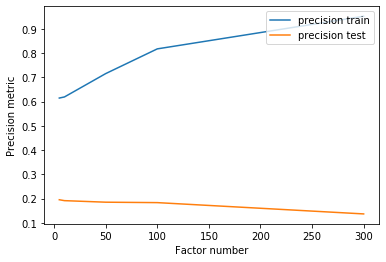

In [24]:
result_plot(factors=factors, precision_train=precision_train, precision_test=precision_test)

In [25]:
def time_plot(factors, time):
    plt.xlabel('Factor number')
    plt.ylabel('Time in seconds')
    plt.plot(factors, time, label='time')
    plt.legend(loc='upper right')
    plt.show()

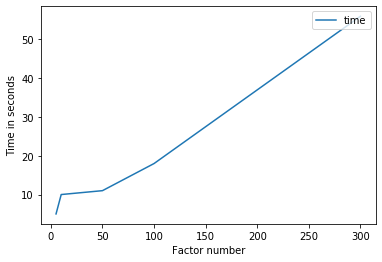

In [26]:
time_plot(factors=factors, time=time)

Самые хорошие результаты на тестовой выборке - при небольшом количестве факторов : 5 факторов и регуляризация 0.1.
Однако при увеличении количества факторов (до 100) качество результатов на тестовой выборке чуть снижается, но несильно. Резкое снижение качества происходит при 300 факторов и резко увеличивается время обучения.
При этом результаты на тренировочной выборке, наоборот, растут с увеличением количества факторов --> переобучение.

Разные значения регуляризационной поправки не сильно влияют на результат. Ключевым параметром здесь является именно количество факторов.